# UCI Household Power Consumption - Main Notebook

This notebook reads the semicolon-separated TXT from the UCI dataset, cleans and converts it to kWh, then performs daily aggregation, plotting, and simple linear forecasting.

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analyzer import EnergyAnalyzer
%matplotlib inline

## 1. Configure the TXT path
Set `TXT_PATH` to your downloaded file (semicolon-separated).

In [2]:

# Example path; change it to your actual file location
TXT_PATH = "E:\OneDrive\SIT\EE 551\COURSE PROJEST\code/household_power_consumption.txt"
TXT_PATH


'E:\\OneDrive\\SIT\\EE 551\\COURSE PROJEST\\code/household_power_consumption.txt'

## 2. Load & Clean the UCI TXT

- Separator: `;`
- Join Date+Time into `datetime`
- Replace `?` with NaN and drop missing
- Convert Global_active_power (kW) to per-minute energy (kWh) assuming 1-minute sampling: kW/60

In [3]:

df = pd.read_csv(
    TXT_PATH,
    sep=';',
    parse_dates={'datetime': ['Date', 'Time']},
    na_values='?',
    low_memory=False
)

# Drop rows with NaNs in key columns
df = df.dropna(subset=[
    'datetime', 'Global_active_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
])

# Ensure numeric types
num_cols = ['Global_active_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=num_cols)

# Convert kW to kWh per 1-minute interval
df['energy_kwh'] = df['Global_active_power'] / 60.0
df['date'] = df['datetime'].dt.date

print("Rows after cleaning:", len(df))
display(df.head())


C:\Users\OWENLU\AppData\Local\Temp\ipykernel_9920\146864443.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\OWENLU\AppData\Local\Temp\ipykernel_9920\146864443.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


Rows after cleaning: 157637


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_kwh,date
0,2006-12-16 17:36:00,5.224,0.478,232.99,22.4,0.0,1.0,16.0,0.087067,2006-12-16
1,2006-12-16 17:49:00,3.248,0.000,236.66,13.6,0.0,0.0,17.0,0.054133,2006-12-16
2,2006-12-16 18:02:00,2.772,0.118,238.28,11.6,0.0,0.0,17.0,0.046200,2006-12-16
3,2006-12-16 18:15:00,4.598,0.100,234.25,21.4,0.0,20.0,17.0,0.076633,2006-12-16
4,2006-12-16 18:28:00,3.176,0.000,235.50,13.8,0.0,1.0,17.0,0.052933,2006-12-16


## 3. Daily Aggregation (kWh)

Using `EnergyAnalyzer.daily_usage` method.

In [4]:

analyzer = EnergyAnalyzer(csv_path=None)  # we'll pass DataFrame directly to methods
daily = analyzer.daily_usage(df)
display(daily.head())


,date,daily_kwh
0,2006-12-16,1.514100
1,2006-12-17,4.500467
2,2006-12-18,2.804833
3,2006-12-19,2.113367
4,2006-12-20,2.845433


## 4. Plot Daily Usage

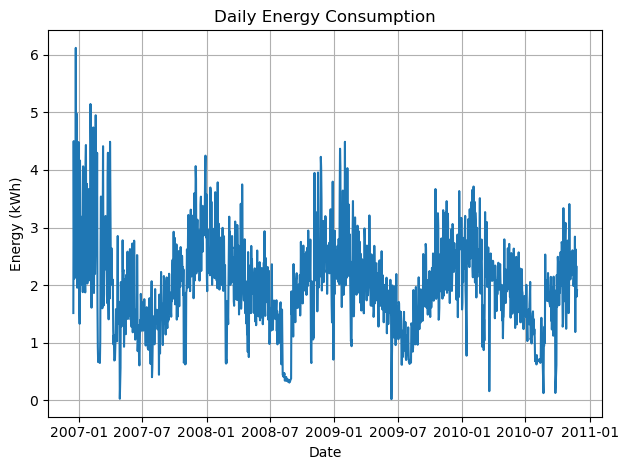

In [5]:

analyzer.plot_daily(daily)
plt.show()


## 5. Linear Forecast for Next 7 Days

In [6]:

pred = analyzer.predict_linear(daily, days_ahead=7)
display(pred)


,date,pred_kwh
0,2010-11-27,1.847863
1,2010-11-28,1.847652
2,2010-11-29,1.847440
3,2010-11-30,1.847229
4,2010-12-01,1.847018
5,2010-12-02,1.846807
6,2010-12-03,1.846596


## 6. Save Outputs

## 7. Data Quality Validation (Part 1: while loop, Part 2: list comprehension & lambda)
Demonstrates the validate_data_quality method which uses:
- while loop for retry logic
- list comprehension to find invalid rows
- lambda function for data filtering


In [7]:
# Validate and clean data using while loop
cleaned_df = analyzer.validate_data_quality(df, max_retries=3)
print(f"Original rows: {len(df)}, Cleaned rows: {len(cleaned_df)}")
print(f"Removed {len(df) - len(cleaned_df)} invalid rows")


Original rows: 157637, Cleaned rows: 157637
Removed 0 invalid rows


## 8. Generator Function (Part 2: Generator)
Demonstrates the generate_daily_stats generator function for memory-efficient processing.


In [8]:
# Use generator to process daily statistics
stats_generator = analyzer.generate_daily_stats(daily.head(10))

# Convert generator to list to display
stats_list = list(stats_generator)
print(f"Generated {len(stats_list)} daily statistics")
print("\nFirst 3 entries:")
for i, stat in enumerate(stats_list[:3]):
    print(f"  Day {i+1}: {stat['date']} - {stat['daily_kwh']:.2f} kWh")


Generated 10 daily statistics

First 3 entries:
  Day 1: 2006-12-16 - 1.51 kWh
  Day 2: 2006-12-17 - 4.50 kWh
  Day 3: 2006-12-18 - 2.80 kWh


## 9. Monthly Aggregation

Demonstrates `aggregate_by_month` which uses:
- `collections.defaultdict` (built-in library)
- Dictionary comprehension


In [9]:
# Aggregate daily data by month
monthly_totals = analyzer.aggregate_by_month(daily)
print("Monthly Energy Totals (kWh):")
for month, total in sorted(monthly_totals.items()):
    print(f"  {month}: {total:.2f} kWh")


Monthly Energy Totals (kWh):
  2006-12: 53.67 kWh
  2007-01: 88.03 kWh
  2007-02: 72.40 kWh
  2007-03: 75.61 kWh
  2007-04: 44.87 kWh
  2007-05: 56.72 kWh
  2007-06: 45.25 kWh
  2007-07: 37.91 kWh
  2007-08: 43.95 kWh
  2007-09: 53.22 kWh
  2007-10: 62.90 kWh
  2007-11: 71.19 kWh
  2007-12: 92.88 kWh
  2008-01: 83.69 kWh
  2008-02: 62.93 kWh
  2008-03: 71.60 kWh
  2008-04: 61.91 kWh
  2008-05: 58.76 kWh
  2008-06: 55.26 kWh
  2008-07: 45.56 kWh
  2008-08: 15.99 kWh
  2008-09: 54.82 kWh
  2008-10: 65.05 kWh
  2008-11: 76.69 kWh
  2008-12: 72.73 kWh
  2009-01: 80.94 kWh
  2009-02: 64.12 kWh
  2009-03: 69.91 kWh
  2009-04: 62.84 kWh
  2009-05: 58.10 kWh
  2009-06: 43.17 kWh
  2009-07: 35.34 kWh
  2009-08: 37.26 kWh
  2009-09: 54.65 kWh
  2009-10: 65.20 kWh
  2009-11: 70.61 kWh
  2009-12: 77.90 kWh
  2010-01: 76.20 kWh
  2010-02: 71.01 kWh
  2010-03: 61.38 kWh
  2010-04: 56.94 kWh
  2010-05: 62.43 kWh
  2010-06: 53.72 kWh
  2010-07: 41.07 kWh
  2010-08: 28.13 kWh
  2010-09: 46.69 kWh
  201

## 10. Appliance Class Usage

Demonstrates the `Appliance` and `ApplianceList` classes with:
- `__str__` method for string representation
- Operator overloading (`__add__`) for `ApplianceList`


In [10]:
from appliance import Appliance, ApplianceList

# Create some appliances
microwave = Appliance("Microwave", 1200.0, 10.0)
kettle = Appliance("Kettle", 2000.0, 5.0)
refrigerator = Appliance("Refrigerator", 150.0, 1440.0)

# __str__ method demonstration
print("Appliance objects (using __str__):")
print(f"  {microwave}")
print(f"  {kettle}")
print(f"  {refrigerator}")

# Create ApplianceList objects
kitchen_appliances = ApplianceList([microwave, kettle])
other_appliances = ApplianceList([refrigerator])

# Operator overloading (__add__)
all_appliances = kitchen_appliances + other_appliances

print(f"\nTotal appliances: {len(all_appliances)}")
print(f"Total energy for all appliances: {all_appliances.total_energy_kwh():.3f} kWh")


Appliance objects (using __str__):
  Microwave (1200.0W, 10.0min)
  Kettle (2000.0W, 5.0min)
  Refrigerator (150.0W, 1440.0min)

Total appliances: 3
Total energy for all appliances: 3.967 kWh


In [11]:

daily_out = "daily_ucidata.csv"
pred_out  = "pred_ucidata.csv"
daily.to_csv(daily_out, index=False)
pred.to_csv(pred_out, index=False)
print("Saved:", daily_out, "and", pred_out)


Saved: daily_ucidata.csv and pred_ucidata.csv
